In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
import matplotlib.image as mpimg

In [2]:
# Load MNIST dataset
(X_train, _), (_, _) = mnist.load_data()
X_train = (X_train - 127.5) / 127.5  # Normalization 
X_train = np.expand_dims(X_train, axis=-1)  # Add channel dimension

# Batch and shuffle the data
batch_size = 64
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(60000).batch(batch_size)


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
def build_generator():
    model = models.Sequential([
        layers.Dense(7 * 7 * 256, use_bias=False, input_shape=(100,)),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.Reshape((7, 7, 256)),
        
        layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.ReLU(),
        
        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.ReLU(),
        
        layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', activation='tanh')
    ])
    return model


In [4]:
def build_discriminator():
    model = models.Sequential([
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        
        layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        
        layers.Flatten(),
        layers.Dense(1)
    ])
    return model


In [5]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output)*0.9, real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator = build_generator()
discriminator = build_discriminator()

generator_optimizer = tf.keras.optimizers.Adam(1e-4,beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4,beta_1=0.5)


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [6]:
@tf.function
def train_step(images):
    noise = tf.random.normal([batch_size, 100])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
    
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    


2024-08-26 20:42:51.012737: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1_2/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Epoch 10, Generator Loss: 0.8844152688980103, Discriminator Loss: 1.290507197380066


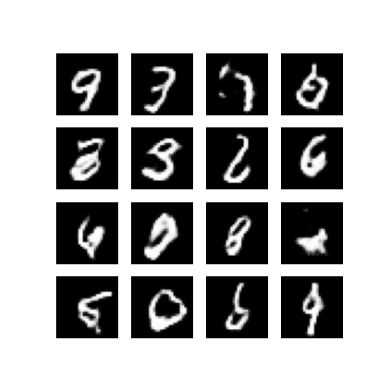

Epoch 20, Generator Loss: 0.8245731592178345, Discriminator Loss: 1.3152233362197876


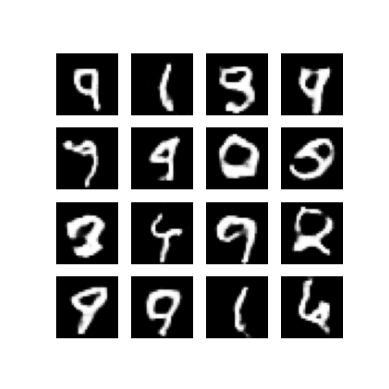

Epoch 30, Generator Loss: 0.8023191094398499, Discriminator Loss: 1.3218638896942139


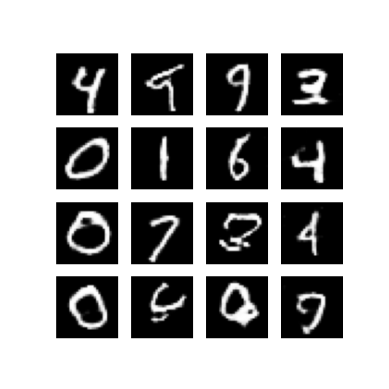

Epoch 40, Generator Loss: 0.8163502216339111, Discriminator Loss: 1.3027026653289795


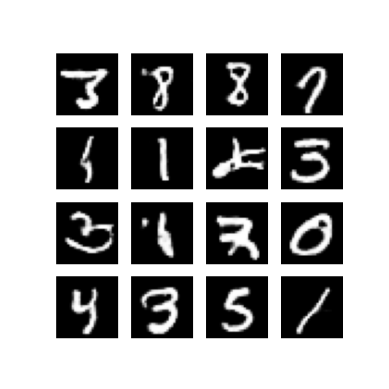

Epoch 50, Generator Loss: 0.8267623782157898, Discriminator Loss: 1.3174567222595215


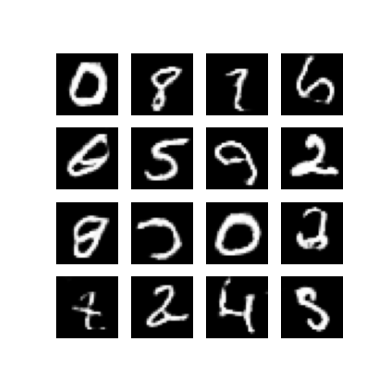

Epoch 60, Generator Loss: 0.8048564195632935, Discriminator Loss: 1.3424066305160522


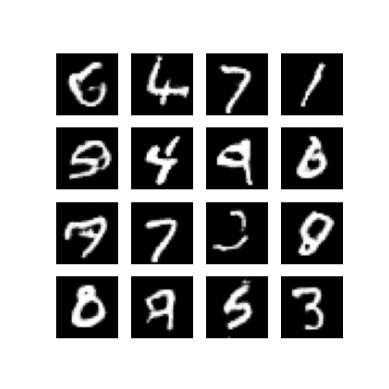

Epoch 70, Generator Loss: 0.8564684391021729, Discriminator Loss: 1.3229960203170776


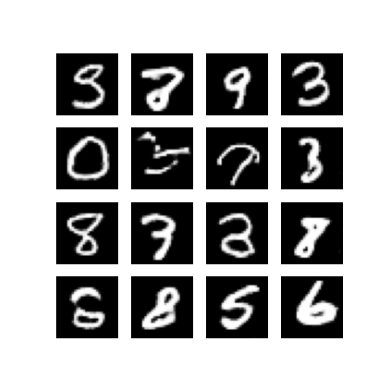

Epoch 80, Generator Loss: 0.8048431873321533, Discriminator Loss: 1.3514692783355713


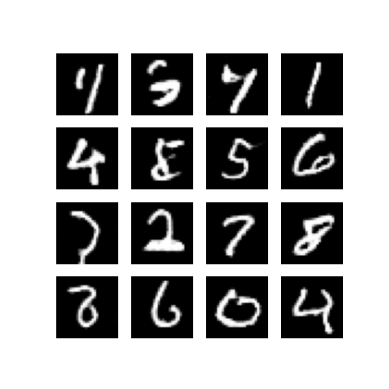

Epoch 90, Generator Loss: 0.7812492251396179, Discriminator Loss: 1.3599798679351807


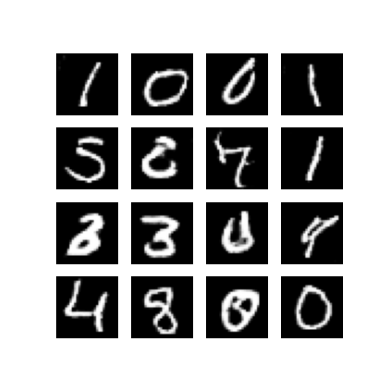

Epoch 100, Generator Loss: 0.8613911867141724, Discriminator Loss: 1.3352510929107666


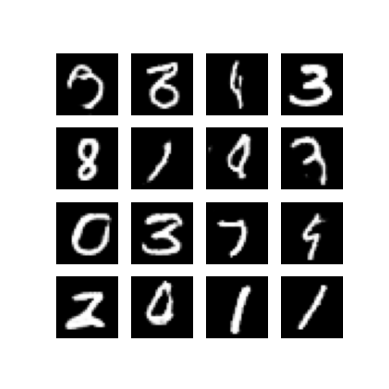

In [7]:
def train_gan(epochs):
    for epoch in range(epochs):
        for image_batch in dataset:
            train_step(image_batch)
        
        # Generate and save images
        if (epoch + 1) % 10 == 0:
            noise = tf.random.normal([batch_size, 100])
            generated_images = generator(noise, training=False)
            
            real_output = discriminator(image_batch, training=False)
            fake_output = discriminator(generated_images, training=False)
            
            gen_loss = generator_loss(fake_output)
            disc_loss = discriminator_loss(real_output, fake_output)
            
            print(f"Epoch {epoch + 1}, Generator Loss: {gen_loss.numpy()}, Discriminator Loss: {disc_loss.numpy()}")
            
            # Generate and save images
            generate_and_save_images(generator, epoch + 1)
            
def generate_and_save_images(model, epoch):
    noise = tf.random.normal([16, 100])
    generated_images = model(noise, training=False)
    
    fig, axs = plt.subplots(4, 4, figsize=(4, 4))
    count = 0
    for i in range(4):
        for j in range(4):
            axs[i, j].imshow(generated_images[count] * 0.5 + 0.5, cmap='gray')
            axs[i, j].axis('off')
            count += 1
    plt.savefig(f'image_at_epoch_{epoch}.png')
    plt.close()

    # Display the saved image
    img = mpimg.imread(f'image_at_epoch_{epoch}.png')
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    
train_gan(epochs=100)
